# Fonction :

> PCA

> Représentation des individus dans le plan principal

> Contribution d'un individu à une composante

> Corrélation pour deux matrices

In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import pickle
import os
import sys
sys.path.append('..')
from edfreader import read_edf
import numpy as np

%pylab inline
import scipy as sc
import pylab as plt
from scipy.io.matlab import mio
import mdp

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


# Fonction

##  PCA

In [2]:
# fontion PCA pour x composantes
def pca(s, x_compo=4, input_dim=6) :
    mdp.activate_extension("parallel")
    flow = mdp.nodes.PCANode(input_dim=input_dim,output_dim=x_compo)
    flow.train(s)
    matrice_de_projection = flow.get_projmatrix()  # matrice de projection
    valeurs_propre = flow.d     # valeurs propre
    #total_variance = flow.explained_variance
    y = flow.execute(s)
    scheduler = mdp.parallel.ProcessScheduler(n_processes=2, verbose=True)
    pflow = mdp.parallel.ParallelFlow([flow],verbose=1)
    pflow.train(s,scheduler)
    y = pflow.execute(s)
    scheduler.shutdown()
    return y, valeurs_propre, matrice_de_projection #, total_variance

## Représentation des individus dans le plan principal

In [3]:
# Représentation des individus dans le plan principal
def representation (matrice_de_projection, nb_signaux, compo1, compo2) :
    plot = plt.scatter (matrice_de_projection[:,compo1], matrice_de_projection[:,compo2], color='k')
    plt.xlabel(u'Composante %s' %(compo1+1))
    plt.ylabel(u'Composante %s' %(compo2+1))
    plt.title(u'Plan %s, %s' %((compo1+1),(compo2+1)))

## Contribution d'un individu à une composante

**Contribution d'un individu dans une composante**

$CTR(k,i) =\frac{p_i C_ik^2 (i)}{\lambda_k} $

> $i$ individu = ligne de la matrice = signaux

> $p_i$ poids de l'individue

> $C_ik$ facteur de l'individue = coordonée de l'individu $i$ pour la composante $k$

> $\lambda_k$ valeur propre de la composante $k$

> $CTR(k,i)$ contribution de l'individu $i$ à la composante $k$

*(Statistique Descriptive Multidimensionnelle (pour les nuls) (10/33) et Introduction à l’analyse des données (28/80))*

In [4]:
# fontion contribution de chaques signaux à chaques composantes
def contribution (matrice_projection, valeurs_propres, nb_signaux, x_compo) :
    k = 0
    contribution = []
    while k < x_compo :
        i = 0
        cont = []
        while i < nb_signaux :
            con = (((matrice_projection[i,k]**2)/nb_signaux)/(valeurs_propres[k]))
            cont.append(con)
            i = i+1
        contribution.append(cont)
        maximum = np.max(contribution[k])
        #print (u'Pour la composante %s,' % (k+1), u'le signal ayant la plus forte contribution est : signal', contribution[k].index(maximum)+1, u'=', maximum)
        k = k+1
   
    
    kplot = 0
    fig_width=12
    plt.figure(figsize=(fig_width, fig_width*2/1.6180))
    while kplot < x_compo :
        index = np.arange(nb_signaux)
        plt.subplot(x_compo, 1, (kplot+1))
        plt.bar(index, contribution[kplot], color='k')
        plt.xlabel(u'Signaux')
        plt.title(u'Contribution à la composante %s' %(kplot+1))
        
        kplot = kplot+1
    plt.tight_layout()
    return contribution

*à vérifier*

**Qualité de la représentation d'un individu** = le cosinus carré de l’angle formé par un point avec sa projection sur le plan

http://campus-douai.gemtech.fr/pluginfile.php/13713/mod_resource/content/0/SP-ADD2.pdf diapo 24


$cos^2 \theta = \frac{C_{ik} ^2 (i)}{||e_i|| ^2}$

> $C_{ik}$ facteur de l'individue

> $||e_i|| ^2 = \sum_{k=1}^p { c_{ik} ^2 }$ 

Lorsque l’angle est proche de 0, c'est-à-dire que l’individu est bien représenté, le cosinus est proche de 1.

Dans le cas inverse, l’angle est proche de 90° et le cosinus est proche de 0. 

In [5]:
# fonction qualité de représentation d'un individu
def qualite_representation(matrice_projection, nb_signaux, x_compo) :
    i = 0
    qualite = []
    while i < nb_signaux :
        mk = 0
        moy = []
        mo = []
        while mk < x_compo :
            mo.append(matrice_projection[i,mk]**2)
            mk = mk+1
        moy = sum(mo)
        #print moy

        k = 0
        qualit = []
        while k < x_compo :
            qual = matrice_projection[i,k]**2 / moy
            #print (u'La qualité de la représentation du signal %s' %(i+1), u'sur l\'axe %s' %(k+1), '=', qual)
            qualit.append(qual)
            k = k+1
        qualite.append(qualit)
        q = np.mat(qualite) # transforme en matrice
        i = i+1
    
    kplot = 0
    fig_width=12
    plt.figure(figsize=(fig_width, fig_width*2/1.6180))
    while kplot < x_compo :
        index = np.arange(nb_signaux)
        plt.subplot(x_compo, 1, (kplot+1))
        plt.bar(index, q[:,kplot], color='k')
        plt.xlabel(u'Signaux')
        plt.title(u'Qualité de la représentation des signaux sur l\'axe %s' %(kplot+1))

        kplot = kplot+1
    plt.tight_layout()
    #return qualite

## Corrélation pour deux matrices

In [6]:
# fonction corrélation pour deux matrices de taille x_compo
def correlation (matrice1, matrice2, x_compo):
    i = 0
    correlation = []
    while i < x_compo :
        j = 0
        corr = []
        while j < x_compo :
            coef = np.corrcoef (matrice1[i], matrice2[j])
            corr.append(coef[0,1])
            j = j+1
        correlation.append(corr)
        i = i+1
    return correlation          

# Tout !

In [7]:
def fig_PCA(signaux, composantes) :
    
    p, v, m = pca(signaux.T, x_compo=composantes, input_dim=signaux.shape[0])
    
    ##########################################################################
    fig_width=12
    plt.figure(figsize=(fig_width, fig_width/1.6180))
    for x in range(composantes) :
        plt.subplot(int(composantes/3), 3 ,x+1)
        plt.plot(p[:, x], c='r')
        plt.title(u'PCA pour composante %s' %(x+1), weight='bold')
        plt.xlabel(u'Temps [ms]')
        plt.ylabel(u'Vecteurs propres')

    plt.tight_layout()
    plt.show()
    
    ##########################################################################
    #Représentation des individus dans le plan principal
    plt.figure(figsize=(fig_width, fig_width))    
    xfig=0
    for x in range(composantes) :
        for y in range(composantes) :
            if y != x :
                xfig=xfig+1
                plt.subplot(composantes, composantes-1, xfig)
                representation(m, signaux.shape[0], x, y)
    plt.tight_layout()
    plt.suptitle("Représentation des individus dans les plans",y=1.01, fontsize="x-large", weight='bold')
    plt.show()
    
    ##########################################################################
    contri = contribution(m, v, signaux.shape[0], composantes)
    
    ##########################################################################
    qualite_representation(m, signaux.shape[0], composantes)
    
    ##########################################################################
    c_sinusoides = correlation(p, p, composantes)
    #print (c_sinusoides)
    
    plt.figure(figsize=(fig_width, fig_width/1.6180))
    plt.title(u'Corrélation', weight='bold')
    plt.imshow (c_sinusoides, cmap=cm.RdGy, interpolation='nearest', vmin=(-1), vmax=(1)) # interpolation='nearest' pour évité le floutage
    plt.xlabel(u'PCA signal 1')
    plt.xticks(arange(composantes), ('1', '2', '3', '4', '5', '6'))
    plt.ylabel(u'PCA signal 2')
    plt.yticks(arange(composantes), ('1', '2', '3', '4', '5', '6'))
    plt.colorbar()
    plt.show()
    ##########################################################################

# Signaux Eyelink

In [8]:
timeStr = '2017-07-21_142241'
observer = 'laurent'
mode = 'enregistrement'
file = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.pkl')
with open(file, 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')
      
resultats = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.asc')
data = read_edf(resultats, 'TRIALID')
N_trials = exp['N_trials']
N_blocks = exp['N_blocks']
screen_width_px = exp['screen_width_px']
screen_height_px = exp['screen_height_px']
V_X = exp['V_X']
RashBass = exp['RashBass']
stim_tau = exp['stim_tau']
p = exp['p']

In [9]:
g = []
g_p = []
g_n = []
new_g = []
new_g_p = []
new_g_n = []

for block in range(N_blocks) :

    for trial in range(N_trials) :
        trial_data = trial + N_trials*block
        
        
        data_x = data[trial_data]['x']
        trackertime = data[trial_data]['trackertime']

        StimulusOf = data[trial_data]['events']['msg'][14][0] - trackertime[0]
        TargetOn = data[trial_data]['events']['msg'][15][0] - trackertime[0]
        TargetOff = data[trial_data]['events']['msg'][16][0] - trackertime[0]
        saccades = data[trial_data]['events']['Esac']
        
        gradient_x = np.gradient(data_x)
        
        g_x = []
        for t in range (len(trackertime)) :
            if t > StimulusOf-300 and t < StimulusOf + 1319 :
                g_x.append(gradient_x[t])
        g.append(g_x)
        
        # SUPPRESSION DES SACCADES
        new_gradient_x=[]
        new_time=[]
        t=0
        for x_data in range(len(data_x)):
            saccade = None
            for s in range(len(saccades)) :
                if x_data in np.arange((saccades[s][0]-trackertime[0]), (saccades[s][1]-trackertime[0]+1+4)) :
                    saccade = 'yes'
            if not saccade :
                new_gradient_x.append(gradient_x[x_data])
                new_time.append(t)
                t = t+1
            saccade = None
        
        # donne la StimulusOf avec la suppresion des saccades
        new_StimulusOf = StimulusOf
        for s in range(len(saccades)) :
            if StimulusOf > saccades[s][0]-trackertime[0] :
                new_StimulusOf = new_StimulusOf - saccades[s][2]
        new_gx = []
        for t in range (len(new_time)) :
            if t > new_StimulusOf-300 and t < new_StimulusOf + 600 :
                new_gx.append(new_gradient_x[t])
        new_g.append(new_gx)
        
        if p[trial, block, 0] == 1 :
            g_p.append(g_x)
            new_g_p.append(new_gx)
        else :
            g_n.append(g_x)
            new_g_n.append(new_gx)

In [10]:
g = np.asarray(g) # gradient_x total
g_p = np.asarray(g_p) # gradient_x positif total
g_n = np.asarray(g_n) # gradient_x négatif total
new_g = np.asarray(new_g) # gradient_x sans les saccades
new_g_p = np.asarray(new_g_p) # gradient_x positif sans les saccades
new_g_n = np.asarray(new_g_n) # gradient_x négatif sans les saccades

print (g.shape, g_p.shape, g_n.shape)
print(new_g.shape, new_g_p.shape, new_g_n.shape) # attention tous les signaux doivent faire la même taille !!!

(800, 1618) (426, 1618) (374, 1618)
(800, 899) (426, 899) (374, 899)


## Pour g

scheduler initialized with 2 processes
scheduler shutdown


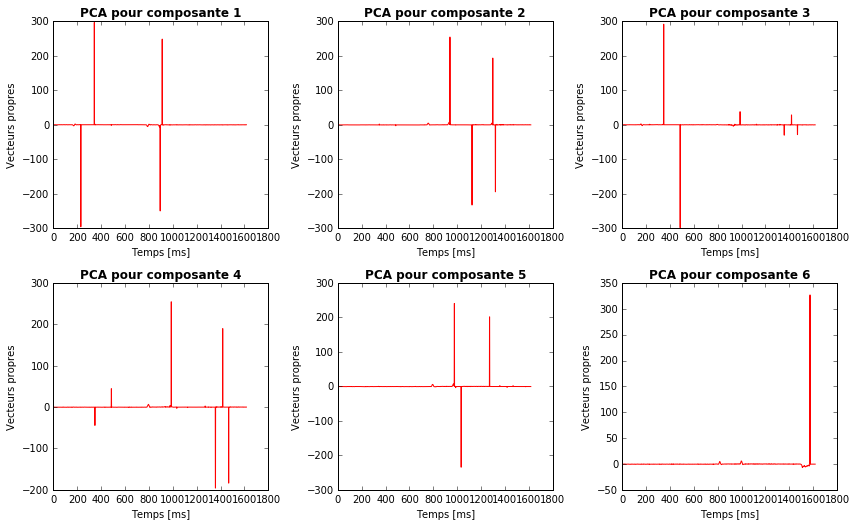

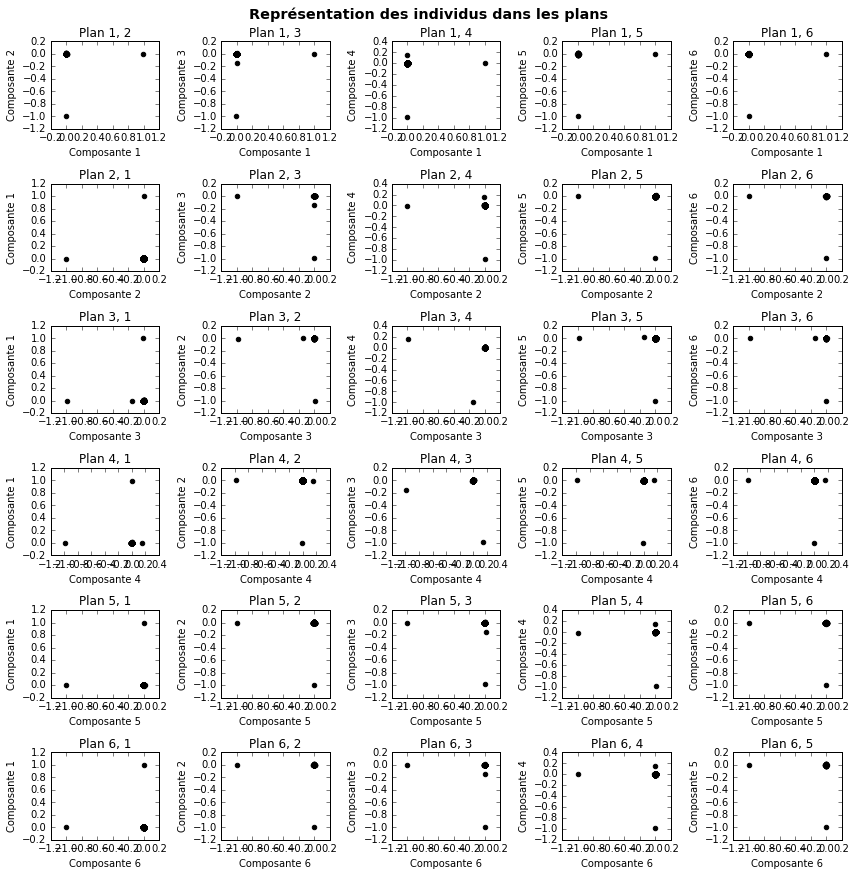

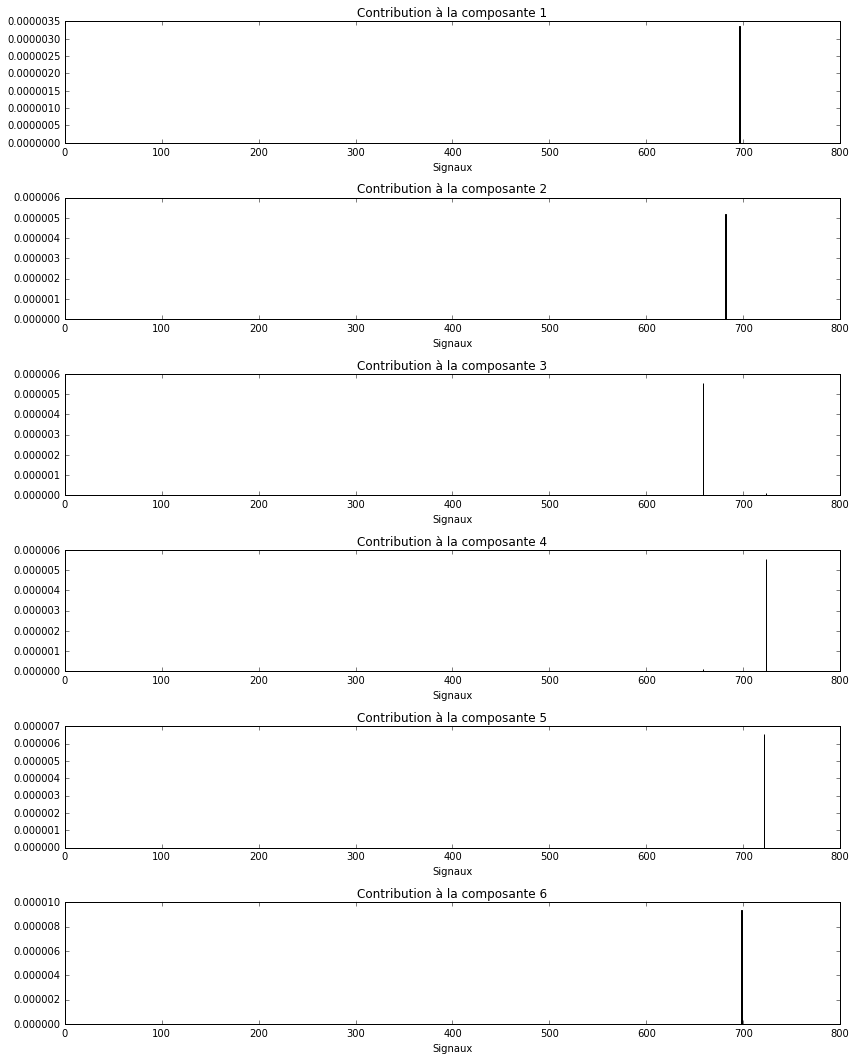

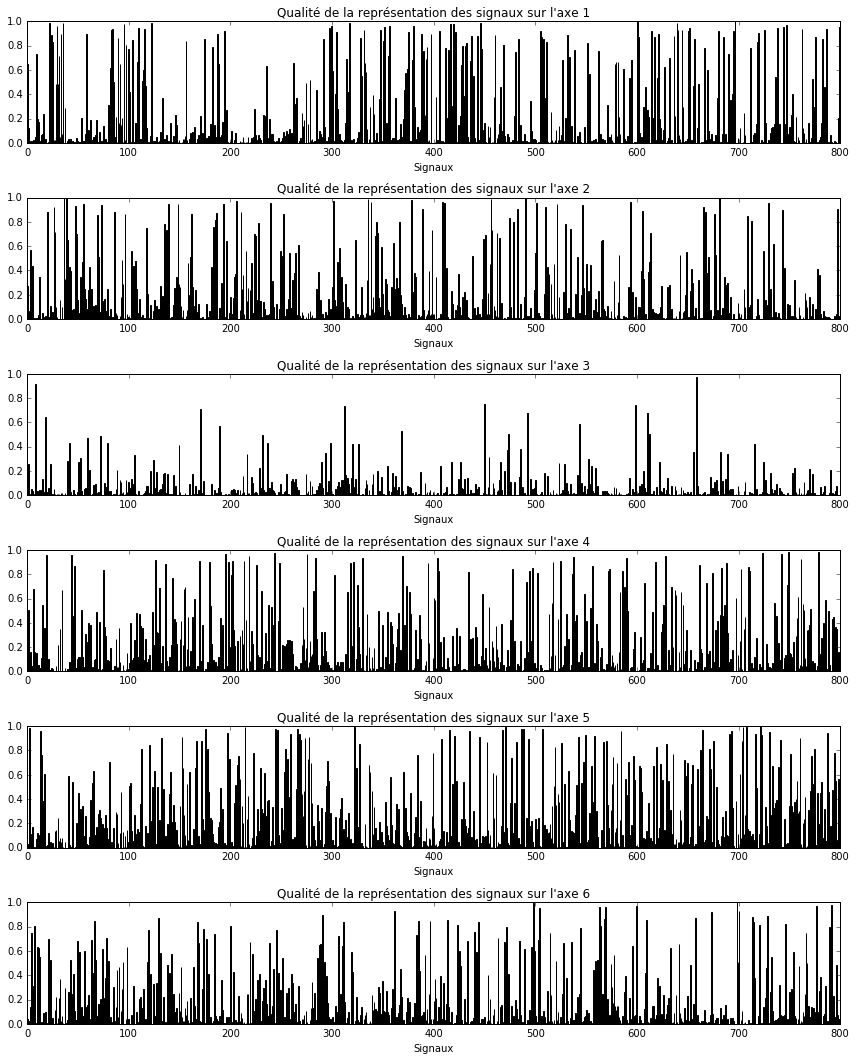

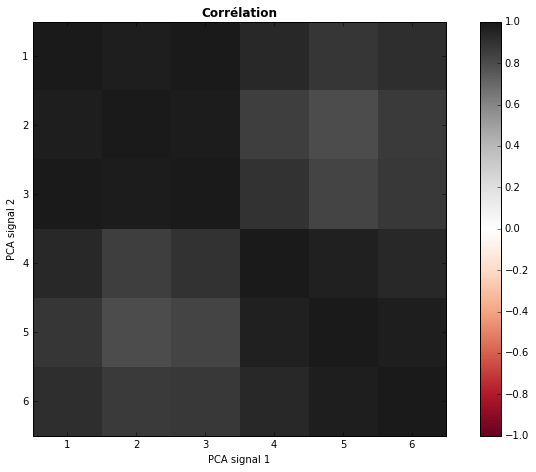

In [11]:
signaux = g
composantes = 6

fig_PCA(signaux, composantes)

# Pour g_p

scheduler initialized with 2 processes
scheduler shutdown


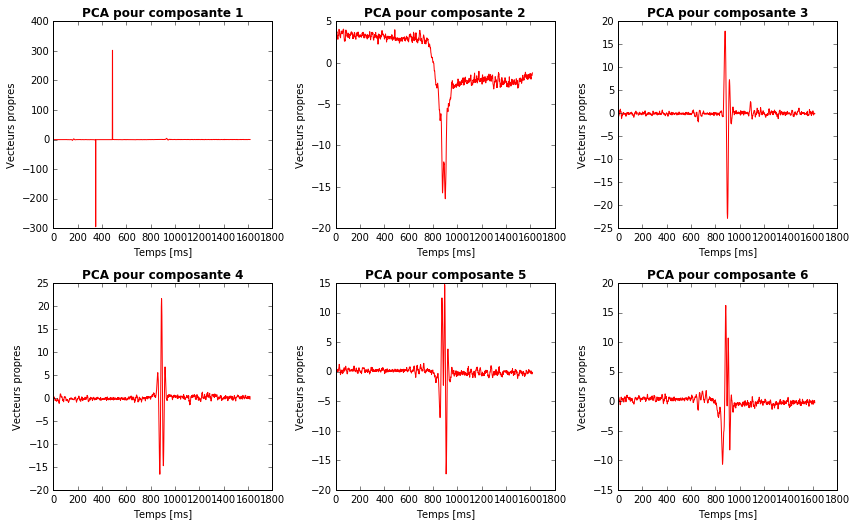

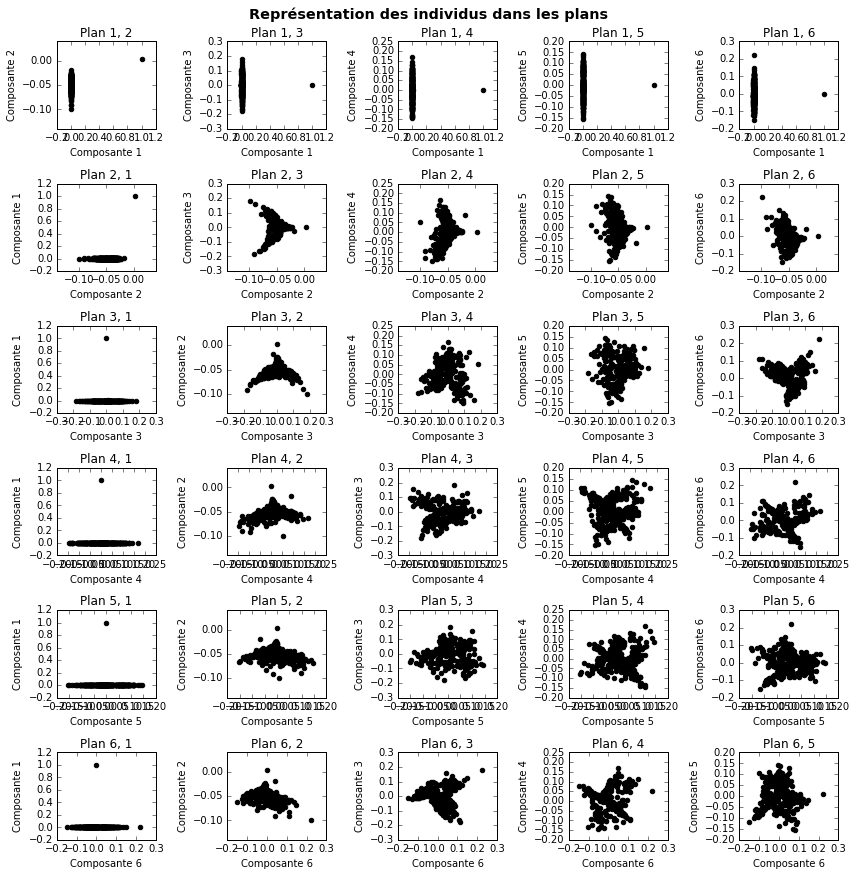

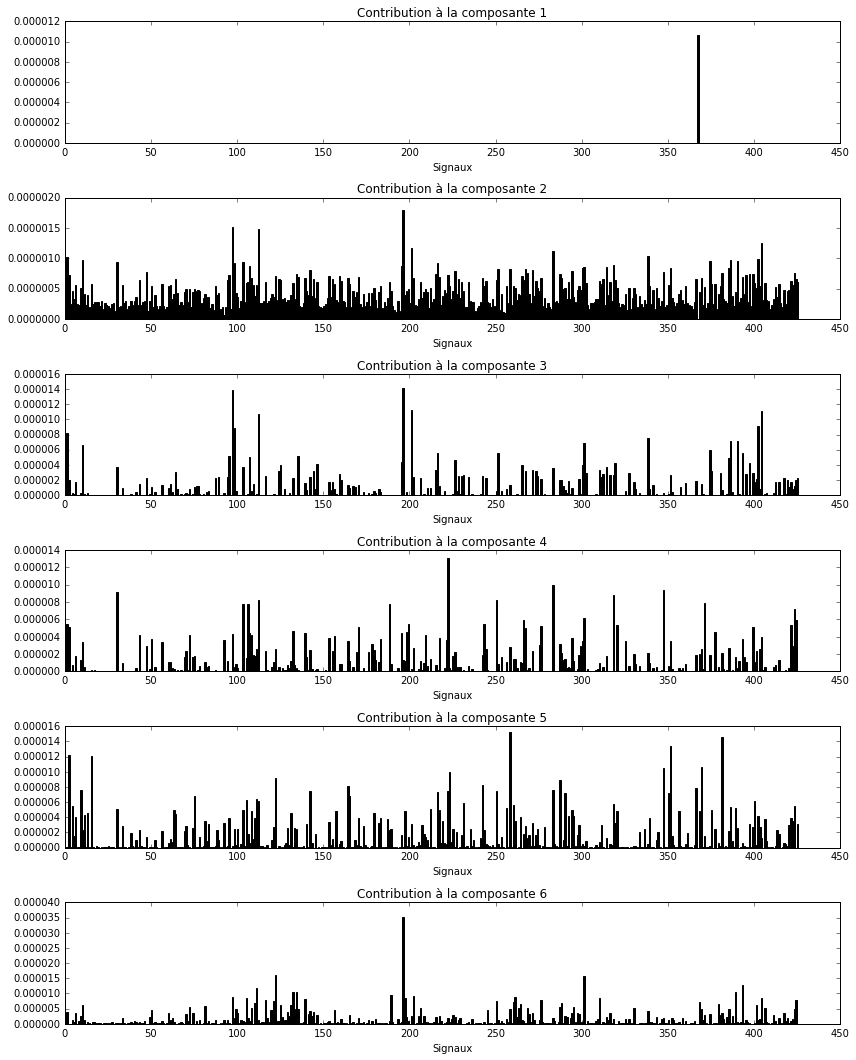

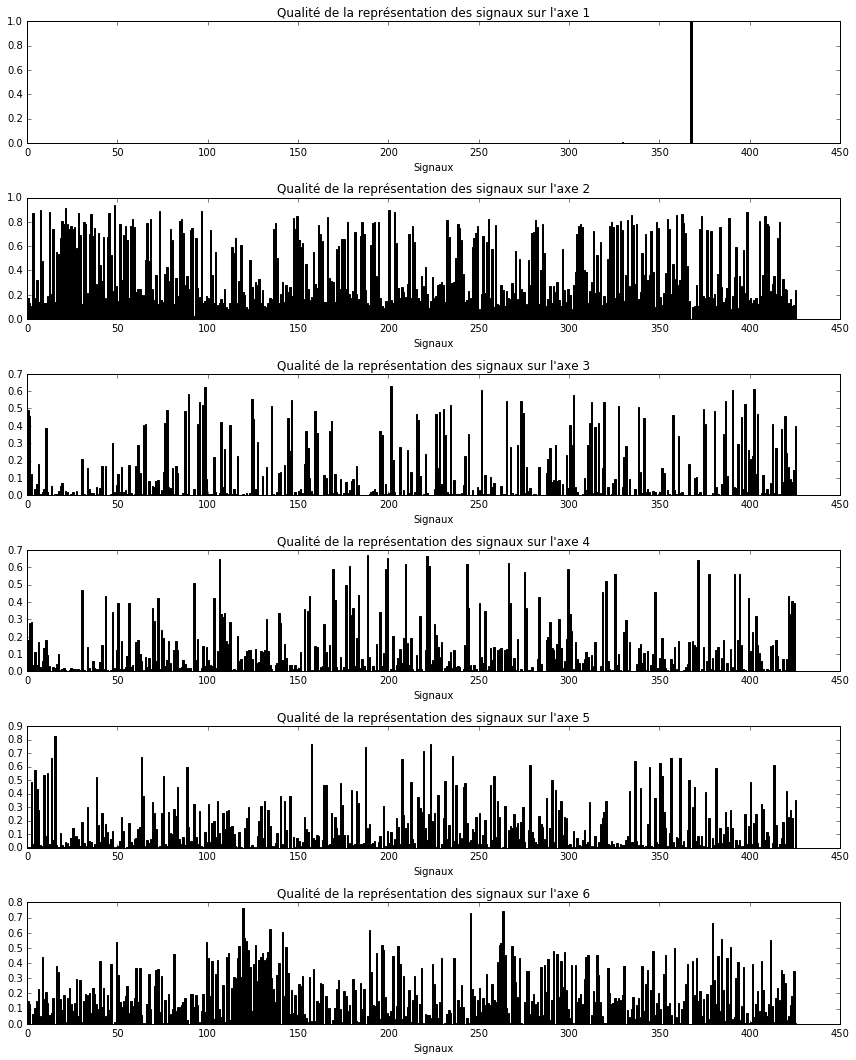

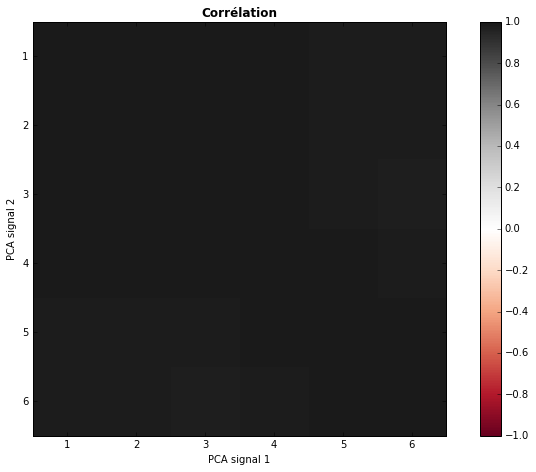

In [12]:
signaux = g_p
composantes = 6

fig_PCA(signaux, composantes)

# Pour g_n

scheduler initialized with 2 processes
scheduler shutdown


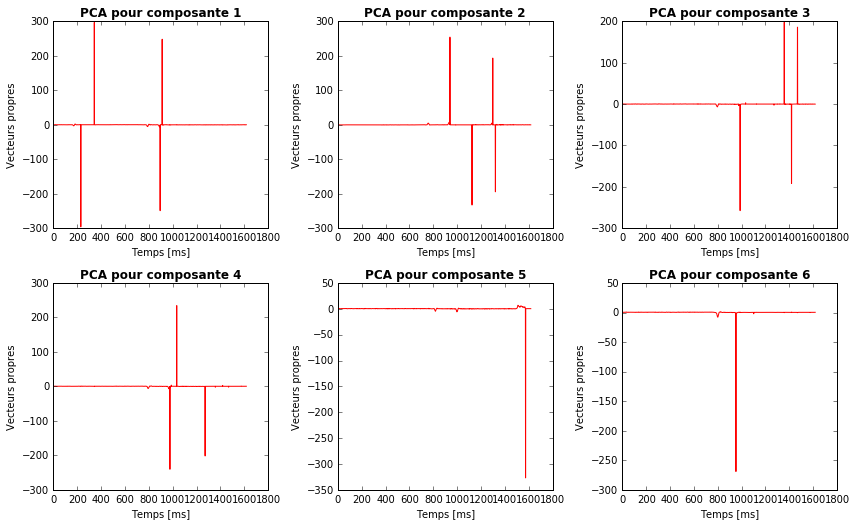

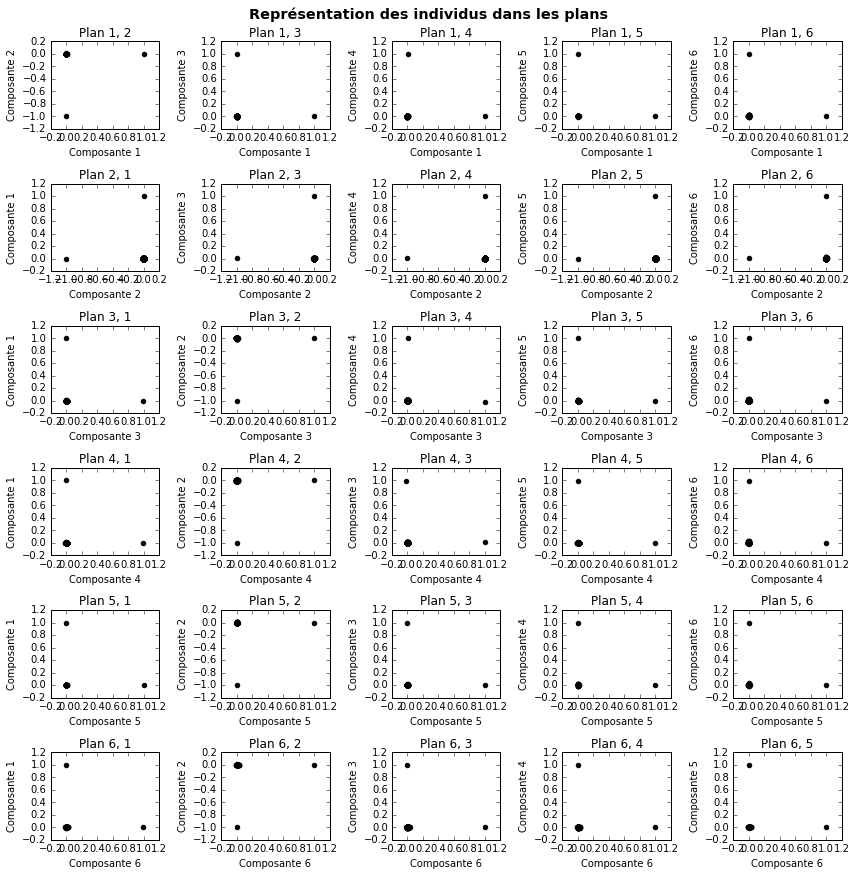

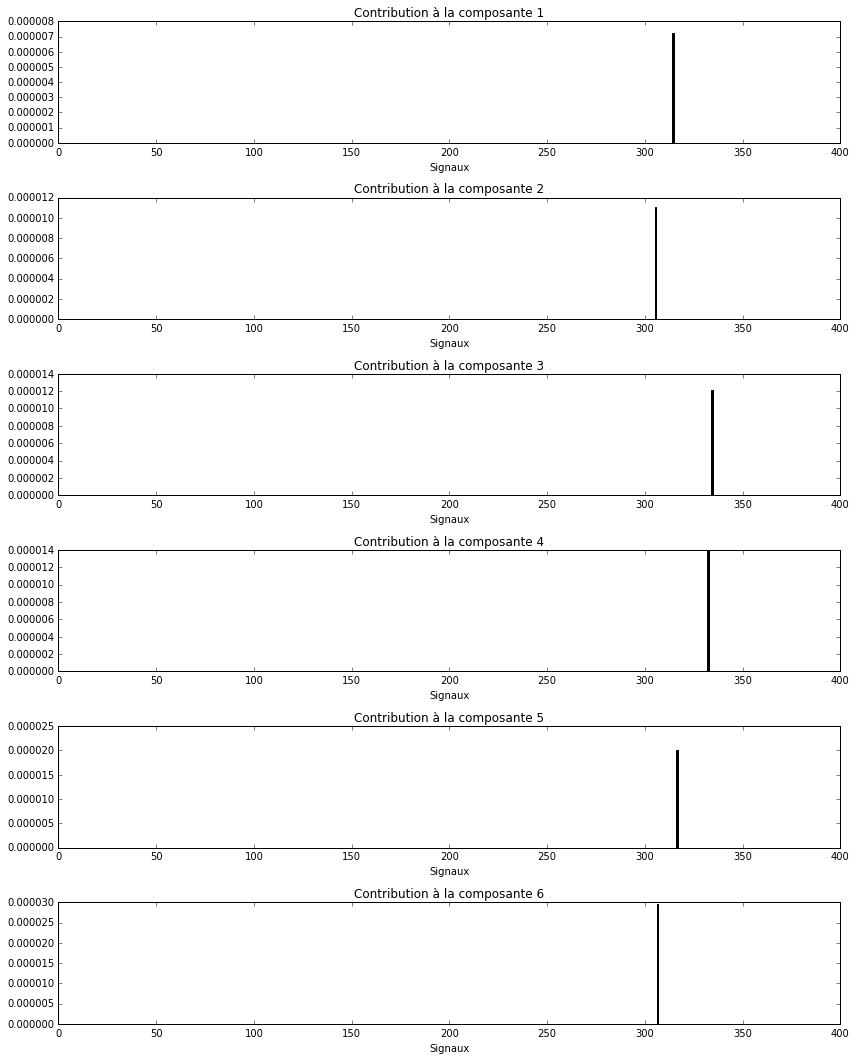

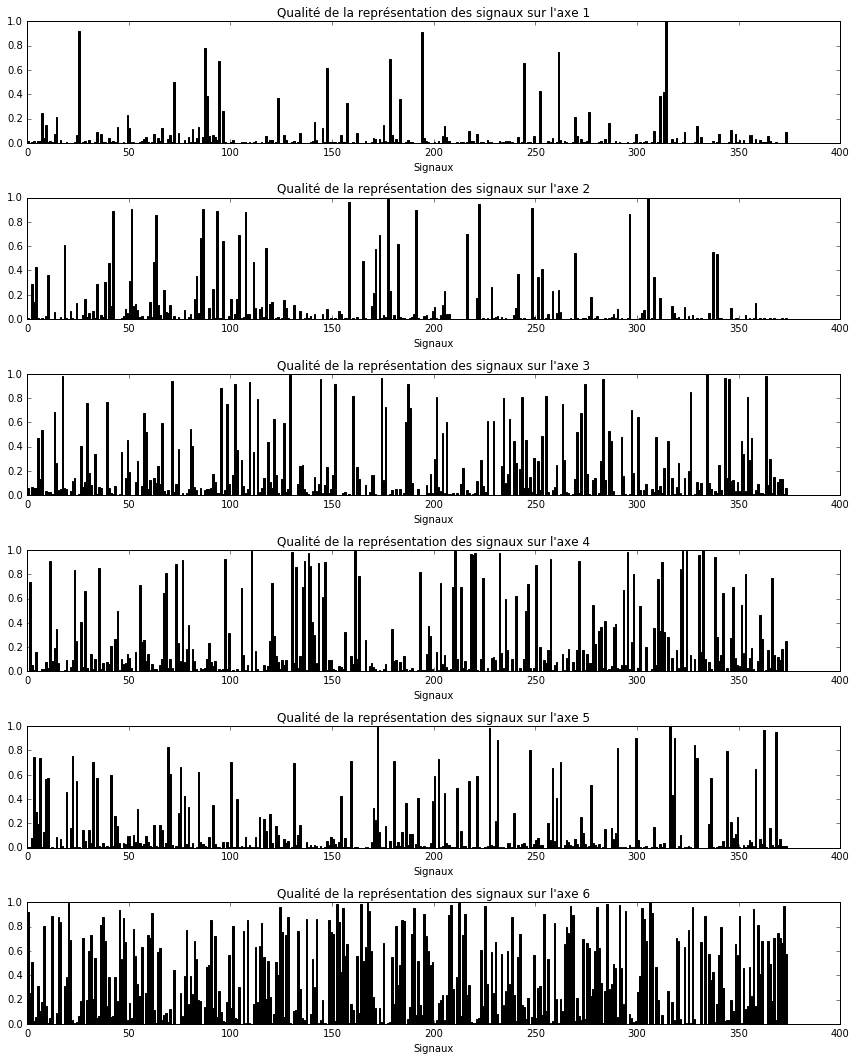

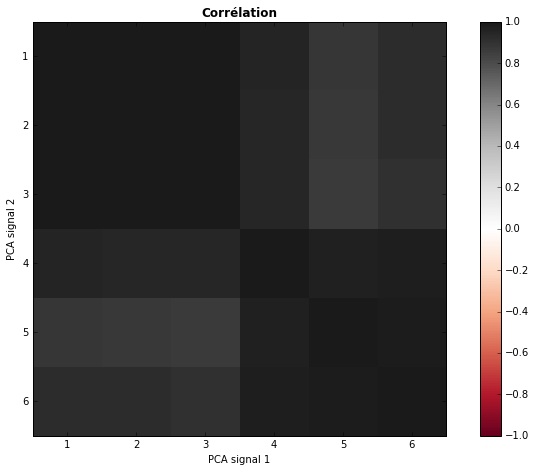

In [13]:
signaux = g_n
composantes = 6

fig_PCA(signaux, composantes)

# Pour new_g

scheduler initialized with 2 processes
scheduler shutdown


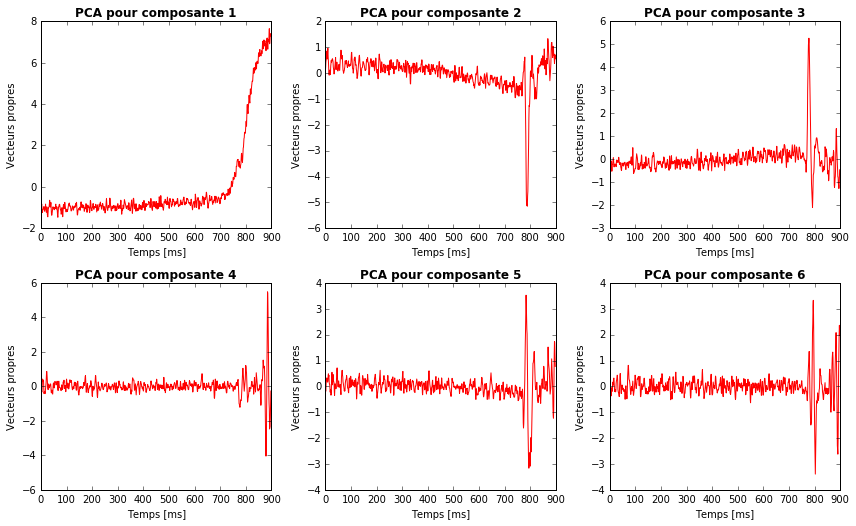

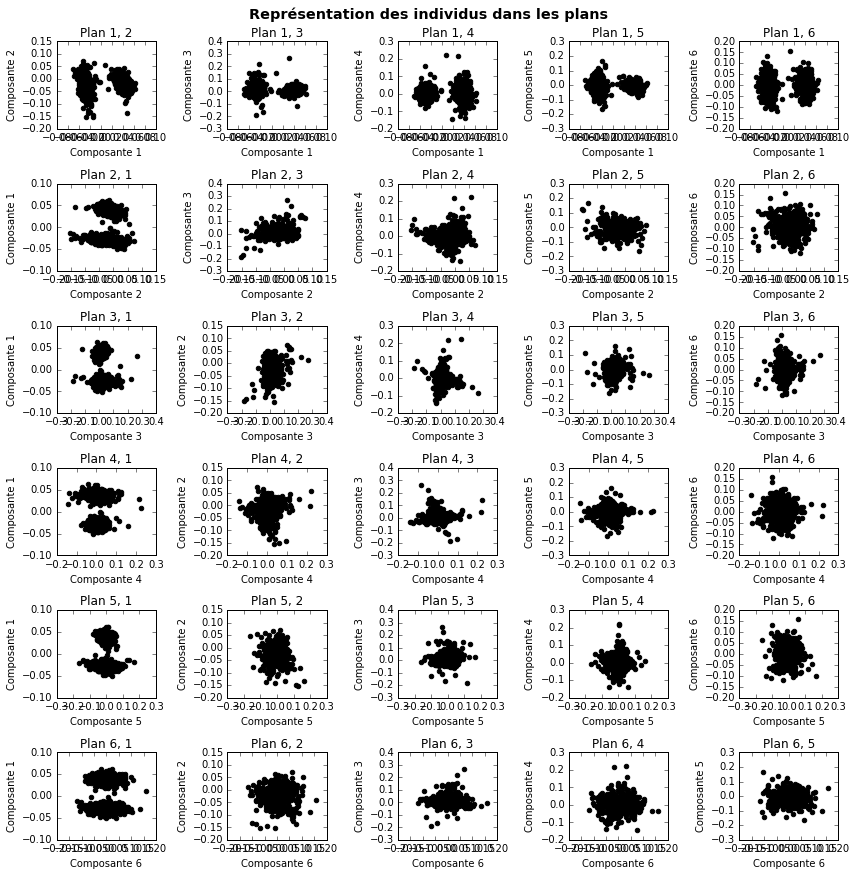

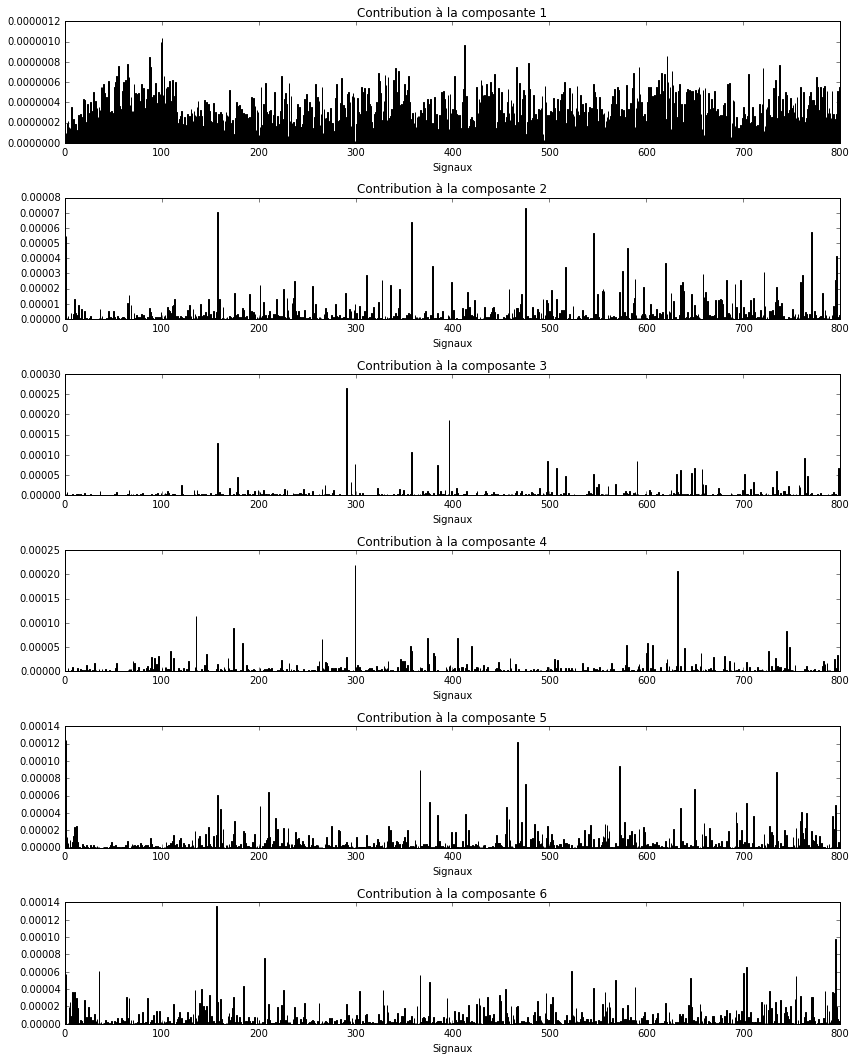

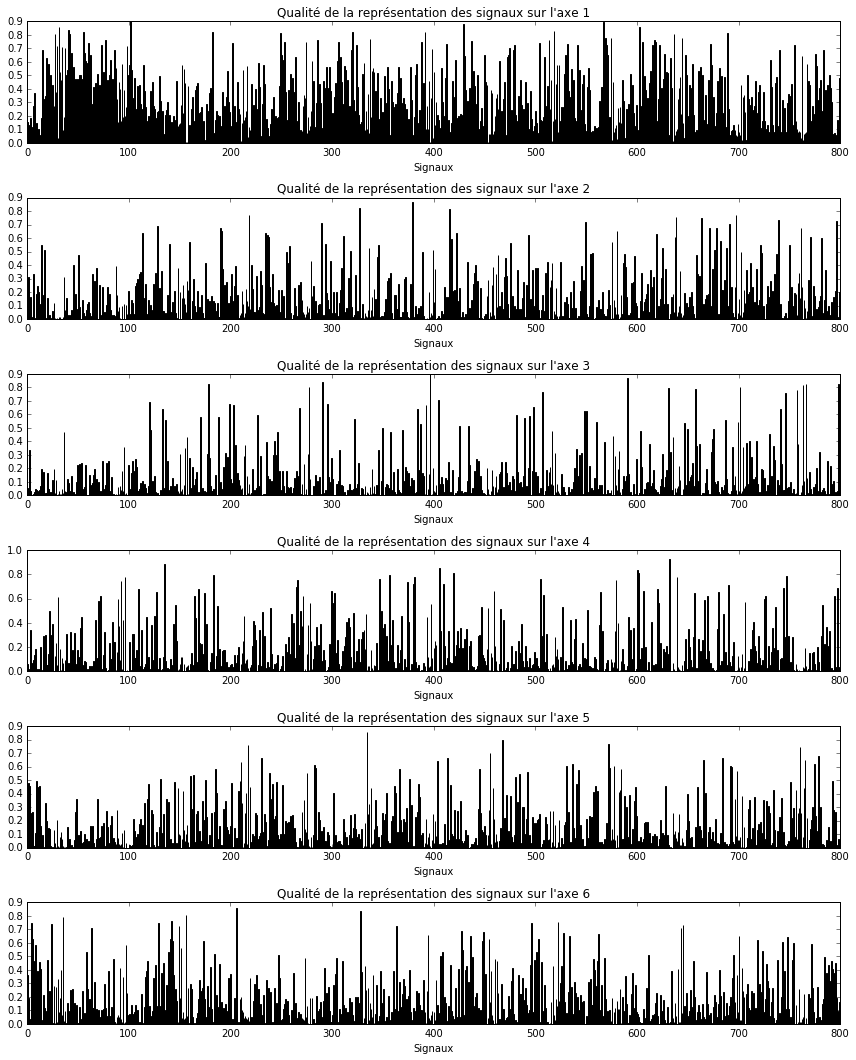

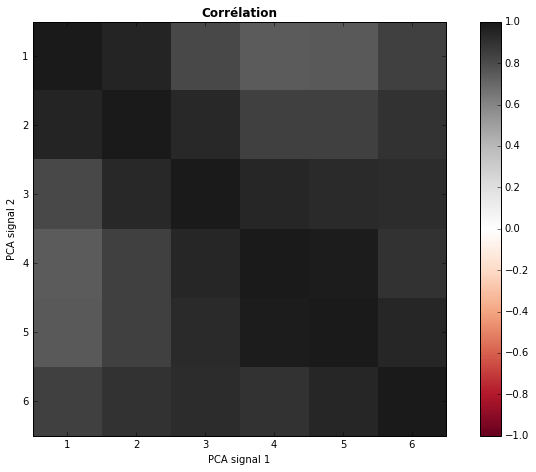

In [14]:
signaux = new_g
composantes = 6

fig_PCA(signaux, composantes)

# Pour new_g_p

scheduler initialized with 2 processes
scheduler shutdown


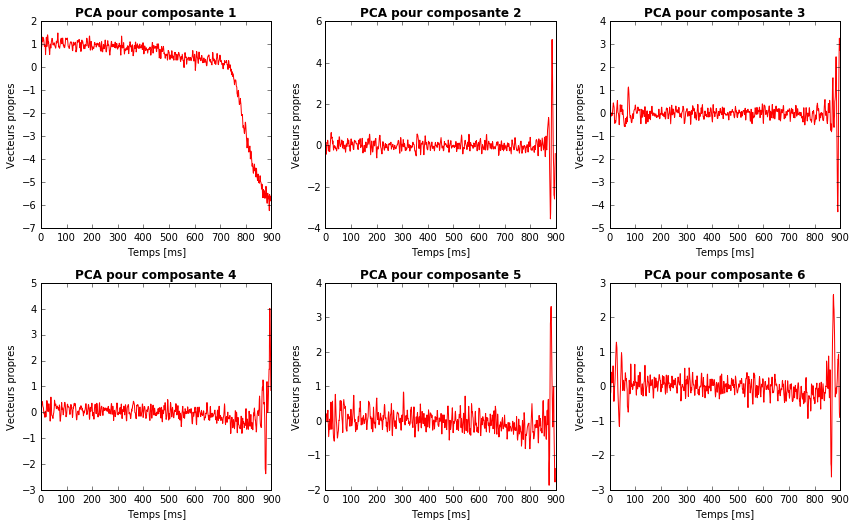

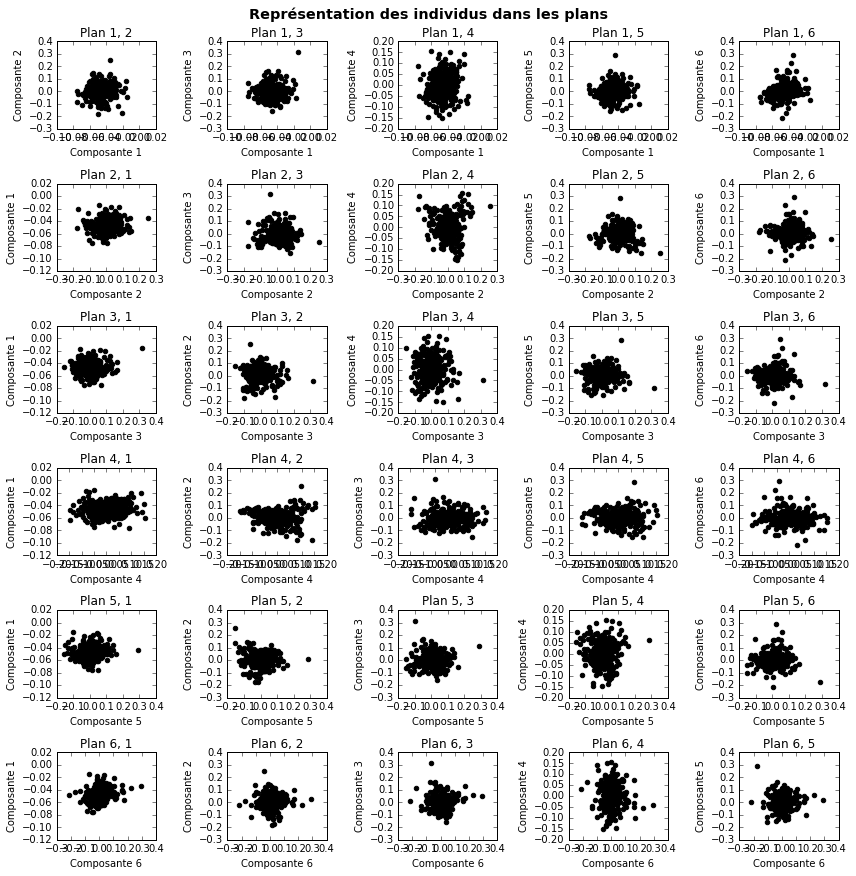

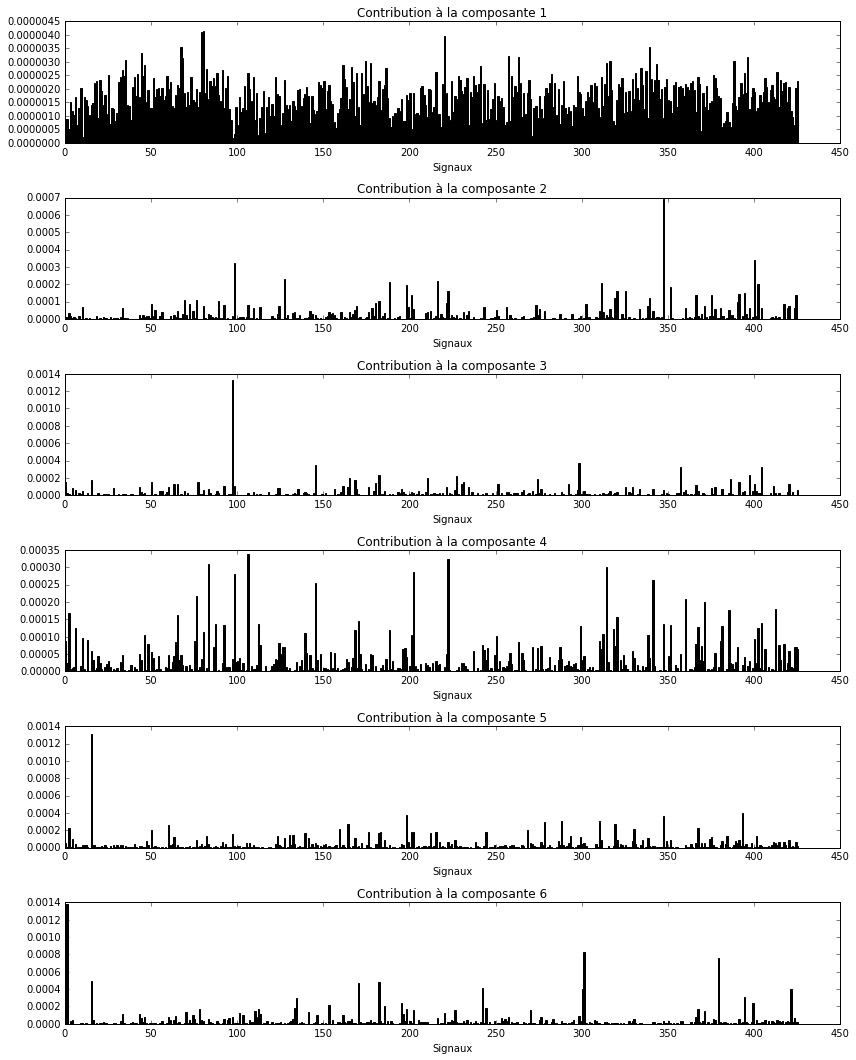

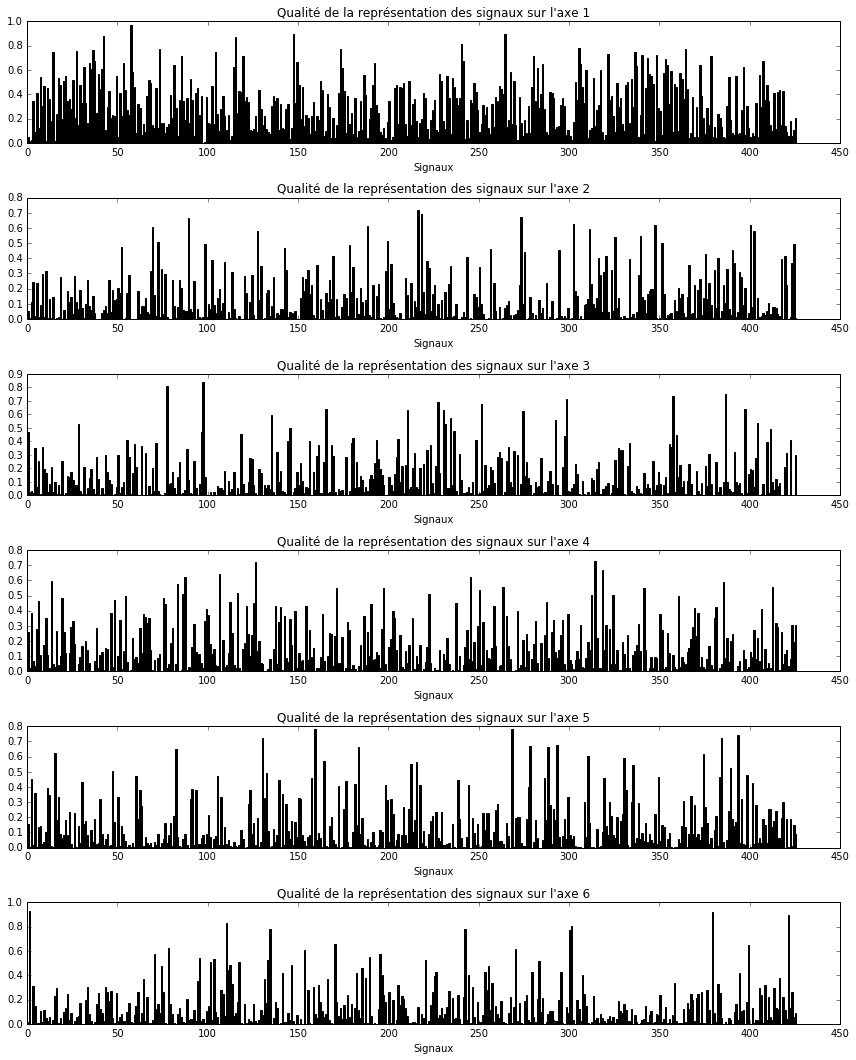

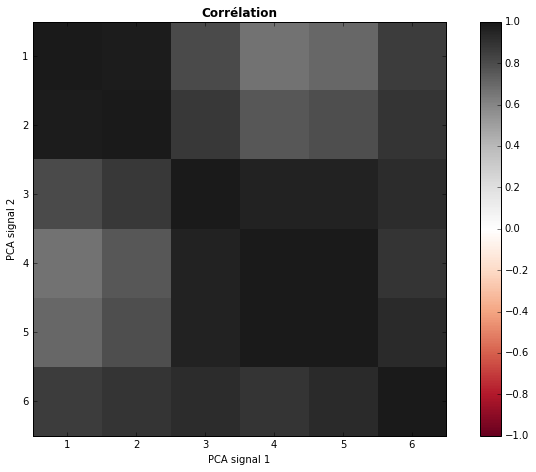

In [15]:
signaux = new_g_p
composantes = 6

fig_PCA(signaux, composantes)

# Pour new_g_n

scheduler initialized with 2 processes
scheduler shutdown


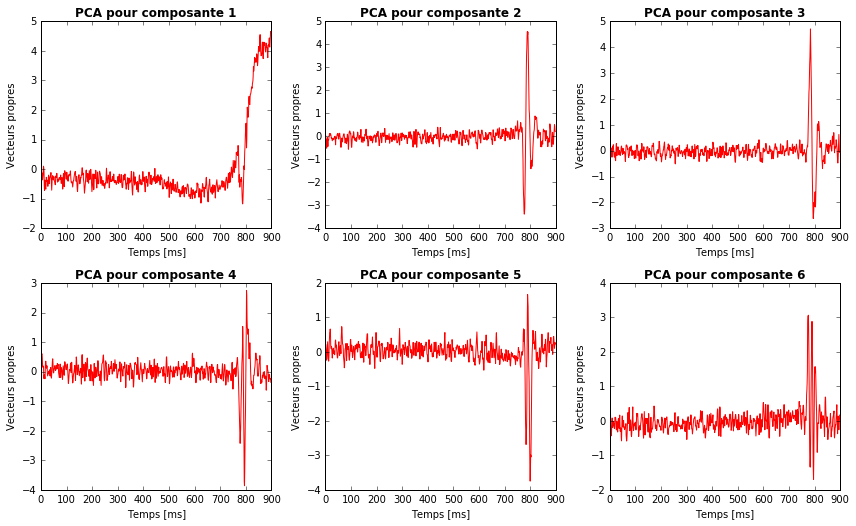

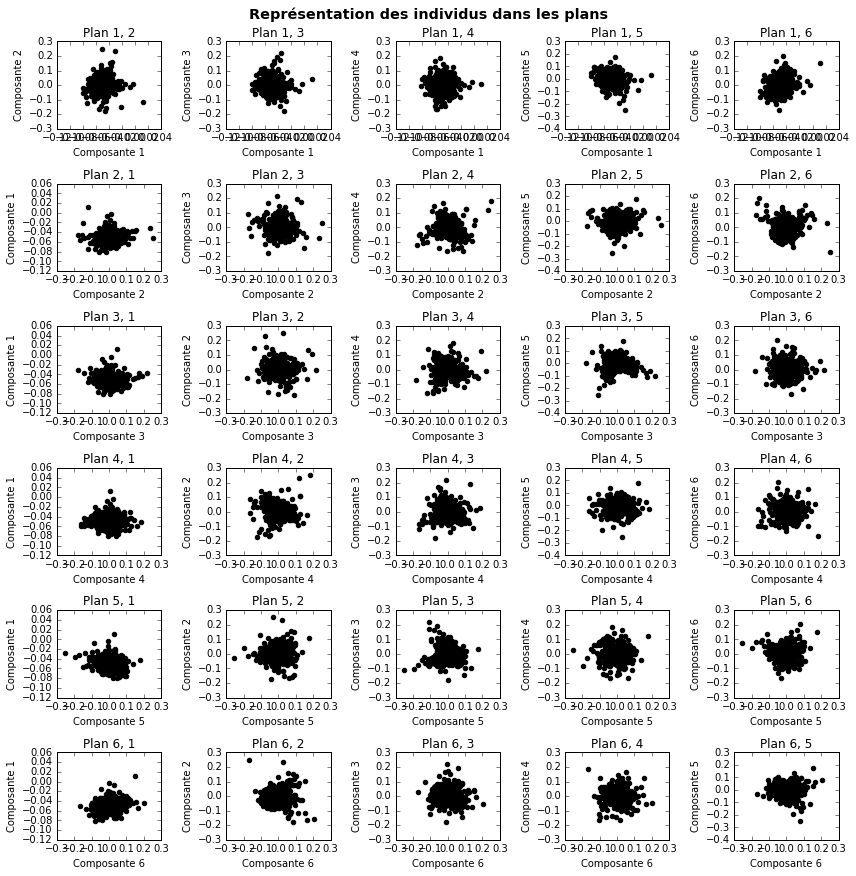

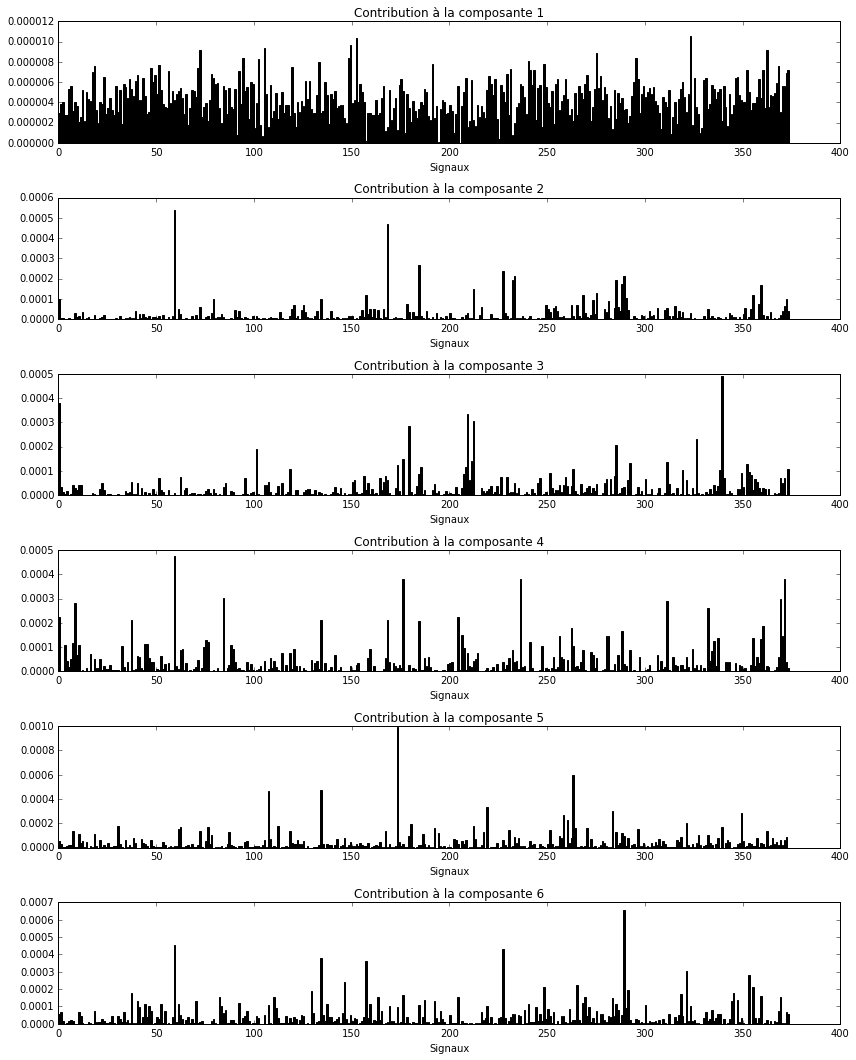

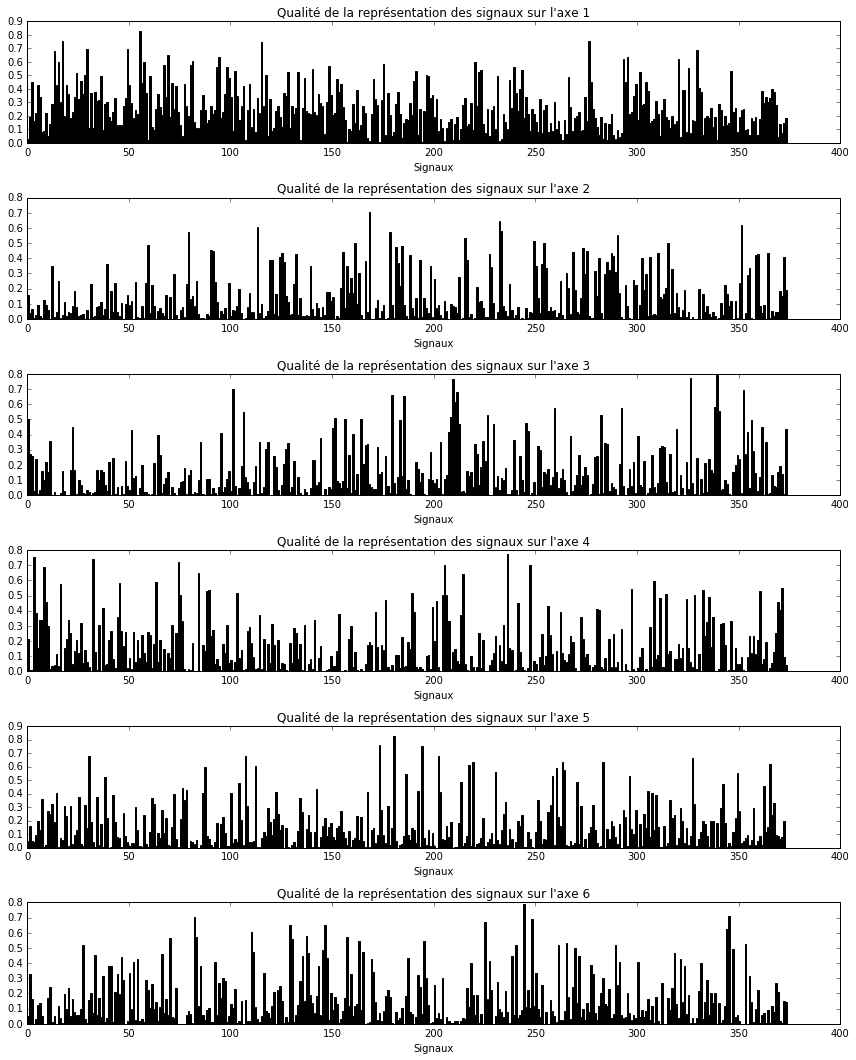

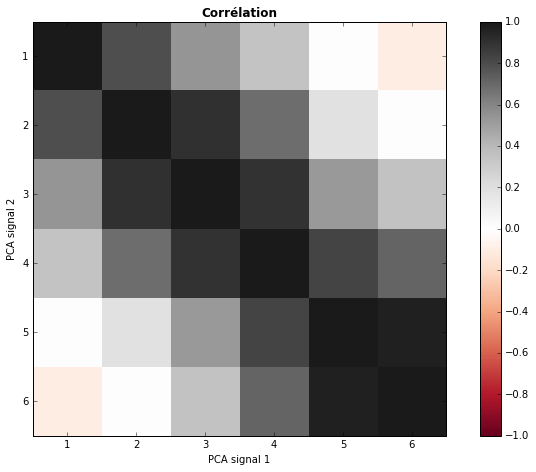

In [16]:
signaux = new_g_n
composantes = 6

fig_PCA(signaux, composantes)